In [3]:
import os
import numpy as np
from tqdm import tqdm
#from operator import itemgetter
#from collections import OrderedDict

from PIL import Image
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision.utils import make_grid

#pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install transformers==4.35.2

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   -------------------------------------- - 7.6/7.9 MB 42.7 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 28.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 61.9 MB/s eta 0:00:00
Using cached requests-2.32.3-py3-none-any.whl (64 kB)


In [3]:
!pip install transformers


In [25]:
%pip install transformers

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizerFast

# Cache dictionary for loaded DataFrames
data_cache = {}

def ensure_directory_exists(directory):
    """Ensure the directory exists, create it if not."""
    Path(directory).mkdir(parents=True, exist_ok=True)


def load_bert_embeddings(data_loader, model, tokenizer, device, save_path):
    """Convert text data to pooled DistilBERT embeddings."""
    embeddings = [] 

    for batch in tqdm(data_loader):
        # Tokenize input text
        inputs = tokenizer(batch, max_length=200, padding=True, truncation=True, return_tensors="pt").to(device)

        # Generate embeddings without gradients
        with torch.no_grad():
            output = model(**inputs)[0]
            pooled_embeddings = torch.mean(output, dim=1).cpu()

        embeddings.append(pooled_embeddings)

    # Save embeddings
    embeddings = torch.cat(embeddings, dim=0)
    torch.save(embeddings, save_path)
    return embeddings


def download_bbc(cache_dir, force_download=False):
    """Download and prepare the BBC news classification dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    github_url = "https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/master/bbc-text.csv"
    file_path = Path(cache_dir) / "bbc-text.csv"

    # Check in cache first
    if "bbc" in data_cache and not force_download:
        return data_cache["bbc"]

    # Download if file doesn't exist or force download
    if not file_path.exists() or force_download:
        df = pd.read_csv(github_url)
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)

    # Map labels to integers
    label_dict = {"business": 0, "entertainment": 1, "sport": 2, "tech": 3, "politics": 4}
    labels = np.array([label_dict[label] for label in df["category"]])

    # Store in cache
    data_cache["bbc"] = (df["text"].values, labels)
    return data_cache["bbc"]


def download_imdb(cache_dir, force_download=False):
    """Download and prepare the IMDB sentiment analysis dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    github_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
    file_path = Path(cache_dir) / "imdb.csv"

    # Check in cache first
    if "imdb" in data_cache and not force_download:
        return data_cache["imdb"]

    # Download if file doesn't exist or force download
    if not file_path.exists() or force_download:
        df = pd.read_csv(github_url)
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)

    # Map labels to integers
    label_dict = {"negative": 0, "positive": 1}
    labels = np.array([label_dict[label] for label in df["sentiment"]])

    # Store in cache
    data_cache["imdb"] = (df["review"].values, labels)
    return data_cache["imdb"]


def subsample_data(data, labels, num_samples=1000, random_state=None):
    """Randomly subsample a specified number of data points with a fixed random state."""
    rng = np.random.default_rng(seed=random_state)  # Create a random number generator with random_state
    indices = rng.choice(len(data), num_samples, replace=False)
    return data[indices], labels[indices]


def prepare_embeddings(dataset, model_name="distilbert-base-uncased", cache_dir=".", batch_size=128):
    """Generate DistilBERT embeddings for a given dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name).to(device)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    save_path = Path(cache_dir) / "distilbert_embeddings.pt"
    return load_bert_embeddings(data_loader, model, tokenizer, device, save_path)


# # Load and prepare BBC embeddings
# cache_dir = "./cache"
# #bbc_data, bbc_labels = download_bbc(cache_dir)
# #bbc_data, bbc_labels = subsample_data(bbc_data, bbc_labels, random_state=42)  # Subsample with random_state
# #bbc_embeddings = prepare_embeddings(bbc_data, cache_dir=cache_dir)

# # Load and prepare IMDB embeddings
# imdb_data, imdb_labels = download_imdb(cache_dir)
# imdb_data, imdb_labels = subsample_data(imdb_data, imdb_labels, random_state=42)  # Subsample with random_state
# imdb_embeddings = prepare_embeddings(imdb_data, cache_dir=cache_dir)


d:\data_values\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(imdb_data.shape, imdb_labels.shape)

(1000,) (1000,)


In [5]:
print(imdb_data[0])

This was a "sleeper" for sure!! Much better than I thought! Never realizing it was a horror flick.....and who was this gorgeous,baritoned voiced hunk, named Vin Diesel..adding spice and intrigue to this otherwise unpromoted film ??? The monsters in this film were quite unusual, not the same ol run of the mill gobble-you-up types!!The ending was great, too, for a change, not all "bad guys are bad"!!! I give it 2 thumbs up !!!


In [6]:
print(imdb_embeddings.shape)

torch.Size([1000, 768])


In [7]:
X, y = imdb_embeddings, imdb_labels

In [9]:
from datasets import split_data_train_val_test
X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X_numpy, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (500, 768) Validation: (300, 768) Test: (200, 768)
(500, 768) (300, 768) (200, 768)
(500,) (300,) (200,)


In [10]:
# save
import pickle

with open('x_y_embedding_imdb.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [13]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_imdb.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(500, 768) (300, 768) (200, 768)
(500,) (300,) (200,)


In [14]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

300
Noisy training labels shape: (500,)
Epoch [10/1000], Loss: 0.6429
Epoch [20/1000], Loss: 0.6130
Epoch [30/1000], Loss: 0.6017
Epoch [40/1000], Loss: 0.5966
Epoch [50/1000], Loss: 0.5806
Epoch [60/1000], Loss: 0.5757
Epoch [70/1000], Loss: 0.5722
Epoch [80/1000], Loss: 0.5642
Epoch [90/1000], Loss: 0.5619
Epoch [100/1000], Loss: 0.5562
Epoch [110/1000], Loss: 0.5524
Epoch [120/1000], Loss: 0.5501
Epoch [130/1000], Loss: 0.5499
Epoch [140/1000], Loss: 0.5457
Epoch [150/1000], Loss: 0.5431
Epoch [160/1000], Loss: 0.5436
Epoch [170/1000], Loss: 0.5388
Epoch [180/1000], Loss: 0.5346
Epoch [190/1000], Loss: 0.5340
Epoch [200/1000], Loss: 0.5358
Epoch [210/1000], Loss: 0.5318
Epoch [220/1000], Loss: 0.5290
Epoch [230/1000], Loss: 0.5312
Epoch [240/1000], Loss: 0.5274
Epoch [250/1000], Loss: 0.5261
Epoch [260/1000], Loss: 0.5216
Epoch [270/1000], Loss: 0.5220
Epoch [280/1000], Loss: 0.5214
Epoch [290/1000], Loss: 0.5198
Epoch [300/1000], Loss: 0.5192
Epoch [310/1000], Loss: 0.5171
Epoch [3

Running evaluator: KNNEvaluator


100%|██████████| 499/499 [00:00<00:00, 4692.15it/s]


KNNEvaluator completed in 0.20 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[4.3291, 6.6256, 8.3782,  ..., 6.2487, 7.2799, 8.6451],
        [6.3899, 6.5291, 7.6399,  ..., 5.7555, 7.5797, 7.1779],
        [4.9791, 4.8113, 6.3299,  ..., 6.3715, 8.2676, 7.8722],
        ...,
        [5.3962, 6.3970, 5.2167,  ..., 6.2271, 7.3398, 5.1944],
        [4.5979, 7.4520, 5.8570,  ..., 3.5817, 4.6774, 4.5399],
        [3.2586, 5.6113, 5.1248,  ..., 3.7839, 6.0883, 4.3908]])
C2 la: tensor([[0.1903, 0.1903, 0.0000,  ..., 0.0000, 0.1903, 0.1903],
        [0.0000, 0.0000, 0.1903,  ..., 0.1903, 0.0000, 0.0000],
        [0.1903, 0.1903, 0.0000,  ..., 0.0000, 0.1903, 0.1903],
        ...,
        [0.1903, 0.1903, 0.0000,  ..., 0.0000, 0.1903, 0.1903],
        [0.1903, 0.1903, 0.0000,  ..., 0.0000, 0.1903, 0.1903],
        [0.1903, 0.1903, 0.0000,  ..., 0.0000, 0.1903, 0.1903]])
C1 la: tensor([[0.1262, 0.2343, 0.3169,  ..., 0.2166, 0.2651, 0.3294],
        [0.2232, 0.2298, 0.2821,  ..., 0.1933, 0.2793, 0.2603],
        [0.1568, 0.1489, 0.2204,  ..., 0.2224, 0.3117, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


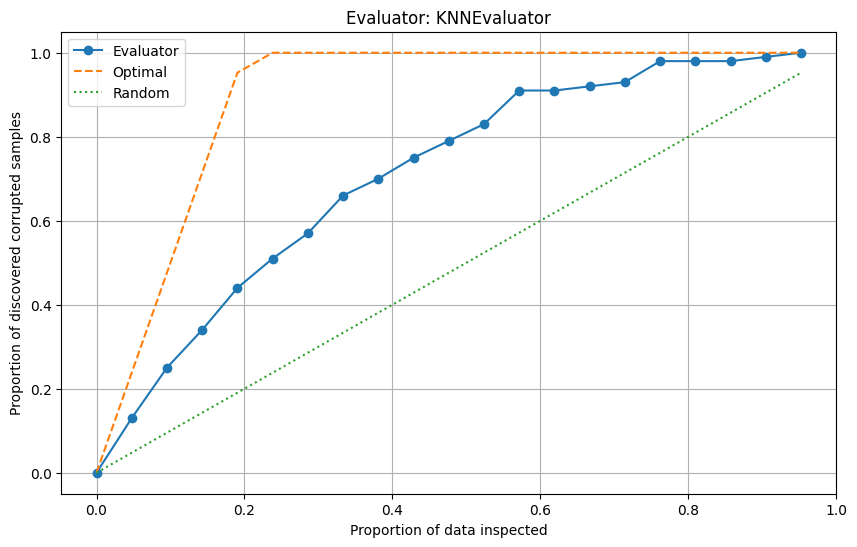

LavaEvaluator: {'found_rates': [0.0, 0.04, 0.06, 0.11, 0.16, 0.21, 0.28, 0.32, 0.41, 0.5, 0.55, 0.59, 0.66, 0.75, 0.78, 0.89, 0.92, 0.97, 0.99, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


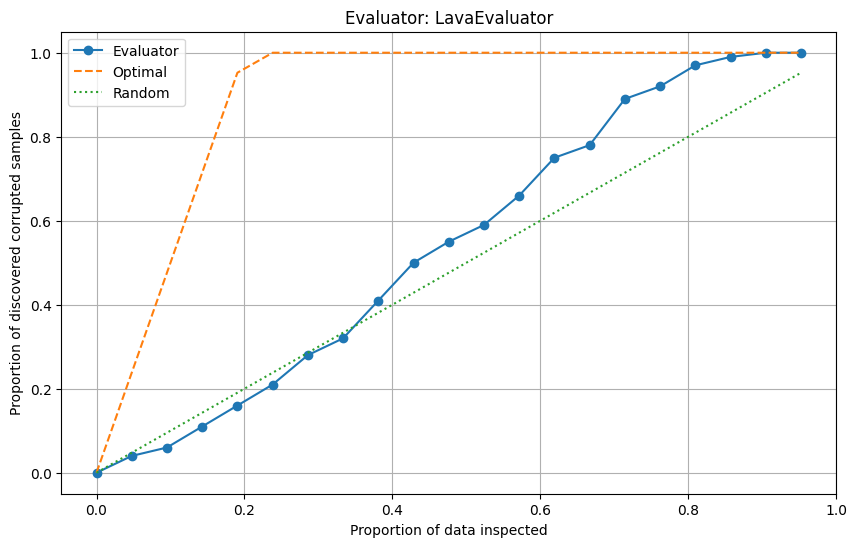

{'KNNEvaluator': {'found_rates': [0.0,
   0.13,
   0.25,
   0.34,
   0.44,
   0.51,
   0.57,
   0.66,
   0.7,
   0.75,
   0.79,
   0.83,
   0.91,
   0.91,
   0.92,
   0.93,
   0.98,
   0.98,
   0.98,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.04,
   0.06,
   0.11,
   0.16,
   0.21,
   0.28,
   0.32,
   0.41,
   0.5,
   0.55,
   0.59,
   0.66,
   0.75,
   0.78,
   0.89,
   0.92,
   0.97,
   0.99,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.1428571

In [15]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

BBC

In [16]:
%pip install transformers

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizerFast

# Cache dictionary for loaded DataFrames
data_cache = {}

def ensure_directory_exists(directory):
    """Ensure the directory exists, create it if not."""
    Path(directory).mkdir(parents=True, exist_ok=True)


def load_bert_embeddings(data_loader, model, tokenizer, device, save_path):
    """Convert text data to pooled DistilBERT embeddings."""
    embeddings = []

    for batch in tqdm(data_loader):
        # Tokenize input text
        inputs = tokenizer(batch, max_length=200, padding=True, truncation=True, return_tensors="pt").to(device)

        # Generate embeddings without gradients
        with torch.no_grad():
            output = model(**inputs)[0]
            pooled_embeddings = torch.mean(output, dim=1).cpu()

        embeddings.append(pooled_embeddings)

    # Save embeddings
    embeddings = torch.cat(embeddings, dim=0)
    torch.save(embeddings, save_path)
    return embeddings


def download_bbc(cache_dir, force_download=False):
    """Download and prepare the BBC news classification dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    github_url = "https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/master/bbc-text.csv"
    file_path = Path(cache_dir) / "bbc-text.csv"

    # Check in cache first
    if "bbc" in data_cache and not force_download:
        return data_cache["bbc"]

    # Download if file doesn't exist or force download
    if not file_path.exists() or force_download:
        df = pd.read_csv(github_url)
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)

    # Map labels to integers
    label_dict = {"business": 0, "entertainment": 1, "sport": 2, "tech": 3, "politics": 4}
    labels = np.array([label_dict[label] for label in df["category"]])

    # Store in cache
    data_cache["bbc"] = (df["text"].values, labels)
    return data_cache["bbc"]


def download_imdb(cache_dir, force_download=False):
    """Download and prepare the IMDB sentiment analysis dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    github_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
    file_path = Path(cache_dir) / "imdb.csv"

    # Check in cache first
    if "imdb" in data_cache and not force_download:
        return data_cache["imdb"]

    # Download if file doesn't exist or force download
    if not file_path.exists() or force_download:
        df = pd.read_csv(github_url)
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)

    # Map labels to integers
    label_dict = {"negative": 0, "positive": 1}
    labels = np.array([label_dict[label] for label in df["sentiment"]])

    # Store in cache
    data_cache["imdb"] = (df["review"].values, labels)
    return data_cache["imdb"]


def subsample_data(data, labels, num_samples=2000, random_state=None):
    """Randomly subsample a specified number of data points with a fixed random state."""
    rng = np.random.default_rng(seed=random_state)  # Create a random number generator with random_state
    indices = rng.choice(len(data), num_samples, replace=False)
    return data[indices], labels[indices]


def prepare_embeddings(dataset, model_name="distilbert-base-uncased", cache_dir=".", batch_size=128):
    """Generate DistilBERT embeddings for a given dataset."""
    ensure_directory_exists(cache_dir)  # Ensure cache directory exists
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name).to(device)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    save_path = Path(cache_dir) / "distilbert_embeddings.pt"
    return load_bert_embeddings(data_loader, model, tokenizer, device, save_path)


# Load and prepare BBC embeddings
cache_dir = "./cache"
bbc_data, bbc_labels = download_bbc(cache_dir)
bbc_data, bbc_labels = subsample_data(bbc_data, bbc_labels, random_state=42)  # Subsample with random_state
bbc_embeddings = prepare_embeddings(bbc_data, cache_dir=cache_dir)

# # Load and prepare IMDB embeddings
# imdb_data, imdb_labels = download_imdb(cache_dir)
# imdb_data, imdb_labels = subsample_data(imdb_data, imdb_labels, random_state=42)  # Subsample with random_state
# imdb_embeddings = prepare_embeddings(imdb_data, cache_dir=cache_dir)


Note: you may need to restart the kernel to use updated packages.


100%|██████████| 16/16 [02:37<00:00,  9.84s/it]


In [17]:
print(bbc_data.shape, bbc_labels.shape)

(2000,) (2000,)


In [18]:
print(bbc_data[0])

playstation 3 chip to be unveiled details of the chip designed to power sony s playstation 3 console will be released in san francisco on monday.  sony  ibm and toshiba  who have been working on the cell processor for three years  will unveil the chip at a technology conference. the chip is reported to be up to 10 times faster than current processors. it is being designed for use in graphics workstations  the new playstation console  and has been described as a supercomputer on a chip. sony has said the cell processor could be used to bridge the gap between movies and video games. special effects and graphics designed for films could be ported for use directly in a video game  sony told an audience at the e3 exhibition in los angeles last year.  cell could also be marketed as an ideal technology for televisions and supercomputers  and everything in between  said kevin krewell  the editor in chief of microprocessor report. the chip will be made of several different processing cores that

In [19]:
print(bbc_embeddings.shape)

torch.Size([2000, 768])


In [20]:
X, y = bbc_embeddings, bbc_labels

In [21]:
from datasets import split_data_train_val_test
X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X_numpy, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (1000, 768) Validation: (600, 768) Test: (400, 768)
(1000, 768) (600, 768) (400, 768)
(1000,) (600,) (400,)


In [22]:
# save
import pickle

with open('x_y_embedding_bbc.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [6]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_imdb.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(500, 768) (300, 768) (200, 768)
(500,) (300,) (200,)


In [7]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

300
Noisy training labels shape: (500,)
Epoch [10/1000], Loss: 0.6432
Epoch [20/1000], Loss: 0.6176
Epoch [30/1000], Loss: 0.5973
Epoch [40/1000], Loss: 0.5934
Epoch [50/1000], Loss: 0.5838
Epoch [60/1000], Loss: 0.5725
Epoch [70/1000], Loss: 0.5684
Epoch [80/1000], Loss: 0.5670
Epoch [90/1000], Loss: 0.5651
Epoch [100/1000], Loss: 0.5576
Epoch [110/1000], Loss: 0.5532
Epoch [120/1000], Loss: 0.5553
Epoch [130/1000], Loss: 0.5481
Epoch [140/1000], Loss: 0.5432
Epoch [150/1000], Loss: 0.5416
Epoch [160/1000], Loss: 0.5406
Epoch [170/1000], Loss: 0.5393
Epoch [180/1000], Loss: 0.5367
Epoch [190/1000], Loss: 0.5339
Epoch [200/1000], Loss: 0.5293
Epoch [210/1000], Loss: 0.5305
Epoch [220/1000], Loss: 0.5330
Epoch [230/1000], Loss: 0.5247
Epoch [240/1000], Loss: 0.5282
Epoch [250/1000], Loss: 0.5255
Epoch [260/1000], Loss: 0.5214
Epoch [270/1000], Loss: 0.5238
Epoch [280/1000], Loss: 0.5191
Epoch [290/1000], Loss: 0.5181
Epoch [300/1000], Loss: 0.5185
Epoch [310/1000], Loss: 0.5122
Epoch [3

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 499/499 [00:00<00:00, 5627.40it/s]


KNNEvaluator completed in 0.18 seconds.
Running evaluator: LavaEvaluator
C1 shape: torch.Size([1, 500, 300])
C2 shape: torch.Size([1, 500, 300])
C1: tensor([[[4.3291, 6.6256, 8.3782,  ..., 6.2487, 7.2799, 8.6451],
         [6.3899, 6.5291, 7.6399,  ..., 5.7554, 7.5797, 7.1779],
         [4.9791, 4.8113, 6.3299,  ..., 6.3715, 8.2676, 7.8722],
         ...,
         [5.3962, 6.3970, 5.2167,  ..., 6.2271, 7.3398, 5.1944],
         [4.5979, 7.4520, 5.8570,  ..., 3.5817, 4.6774, 4.5399],
         [3.2585, 5.6113, 5.1248,  ..., 3.7839, 6.0883, 4.3908]]])
C2: tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])
C1: tensor([[[0.1262, 0.2343, 0.3169,  ..., 0.2166, 0.2651, 0.3294],
         [0.2232, 0.2298, 0.2821,  ..., 0.1933, 0.2793, 0.2603],
         [0.1568, 0.1489, 0.2204,  ..., 0.222

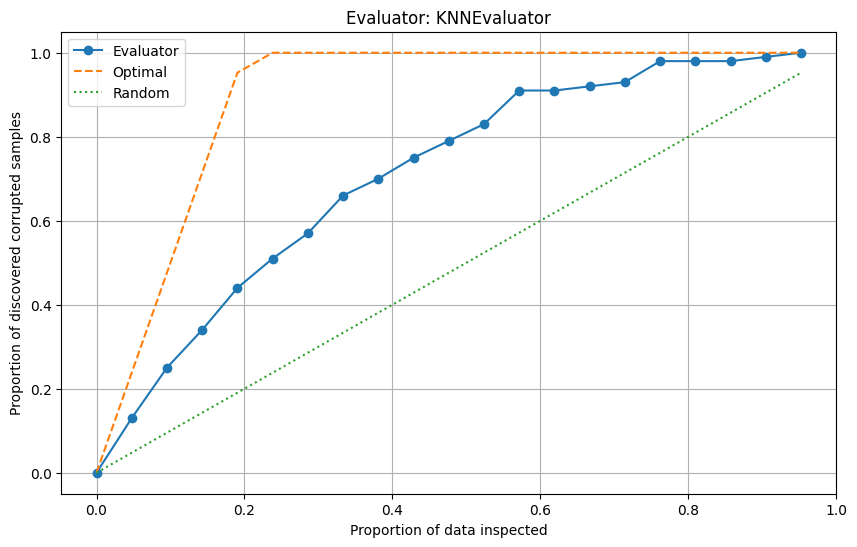

LavaEvaluator: {'found_rates': [0.0, 0.05, 0.14, 0.19, 0.24, 0.31, 0.38, 0.4, 0.45, 0.52, 0.58, 0.67, 0.72, 0.75, 0.82, 0.87, 0.9, 0.93, 0.96, 0.99, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


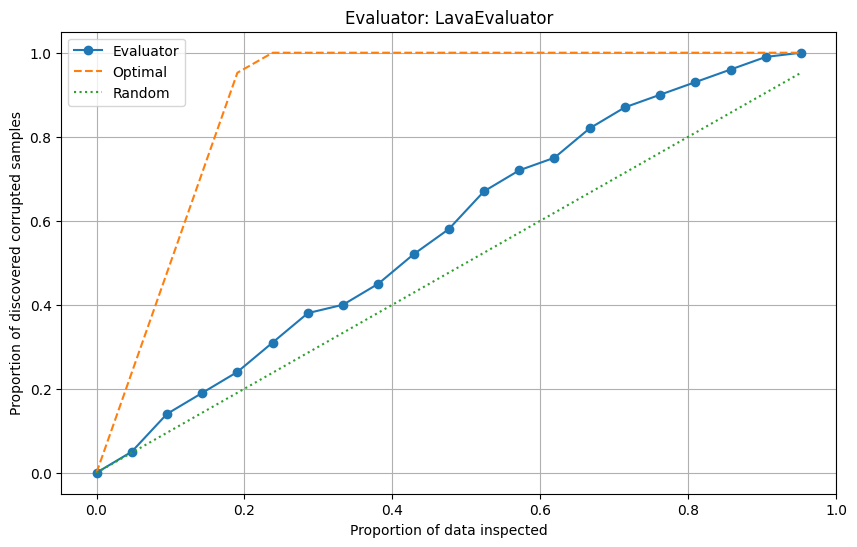

{'KNNEvaluator': {'found_rates': [0.0,
   0.13,
   0.25,
   0.34,
   0.44,
   0.51,
   0.57,
   0.66,
   0.7,
   0.75,
   0.79,
   0.83,
   0.91,
   0.91,
   0.92,
   0.93,
   0.98,
   0.98,
   0.98,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.05,
   0.14,
   0.19,
   0.24,
   0.31,
   0.38,
   0.4,
   0.45,
   0.52,
   0.58,
   0.67,
   0.72,
   0.75,
   0.82,
   0.87,
   0.9,
   0.93,
   0.96,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.1428571

In [8]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [9]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = x_embeddings.copy()
param = add_gauss_noise(X_copy, xt_embeddings, noise_rate=0.2)
X_train_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_noisy.shape)
# train model logistic regression
input_dim = X_train_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: (500, 768)
Epoch [10/1000], Loss: 0.5415
Epoch [20/1000], Loss: 0.5056
Epoch [30/1000], Loss: 0.4843
Epoch [40/1000], Loss: 0.4747
Epoch [50/1000], Loss: 0.4638
Epoch [60/1000], Loss: 0.4558
Epoch [70/1000], Loss: 0.4485
Epoch [80/1000], Loss: 0.4439
Epoch [90/1000], Loss: 0.4451
Epoch [100/1000], Loss: 0.4365
Epoch [110/1000], Loss: 0.4337
Epoch [120/1000], Loss: 0.4328
Epoch [130/1000], Loss: 0.4276
Epoch [140/1000], Loss: 0.4258
Epoch [150/1000], Loss: 0.4253
Epoch [160/1000], Loss: 0.4225
Epoch [170/1000], Loss: 0.4207
Epoch [180/1000], Loss: 0.4210
Epoch [190/1000], Loss: 0.4199
Epoch [200/1000], Loss: 0.4138
Epoch [210/1000], Loss: 0.4154
Epoch [220/1000], Loss: 0.4136
Epoch [230/1000], Loss: 0.4116
Epoch [240/1000], Loss: 0.4113
Epoch [250/1000], Loss: 0.4101
Epoch [260/1000], Loss: 0.4063
Epoch [270/1000], Loss: 0.4062
Epoch [280/1000], Loss: 0.4060
Epoch [290/1000], Loss: 0.4063
Epoch [300/1000], Loss: 0.4050
Epoch [310/1000], Loss: 0.4030
Epoch [3

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 499/499 [00:00<00:00, 6440.01it/s]

KNNEvaluator completed in 0.15 seconds.
Running evaluator: LavaEvaluator


C1 shape: torch.Size([1, 500, 300])
C2 shape: torch.Size([1, 500, 300])
C1: tensor([[[  4.3291, 382.6060,   8.3782,  ...,   6.2487, 372.1006, 379.4364],
         [415.5828, 757.9561, 419.8886,  ..., 416.2645, 811.4714, 828.6723],
         [  4.9791, 382.2868,   6.3299,  ...,   6.3715, 373.1269, 377.3043],
         ...,
         [  5.3962, 382.6605,   5.2167,  ...,   6.2271, 373.6762, 378.2625],
         [  4.5979, 384.0905,   5.8570,  ...,   3.5817, 369.7249, 379.3459],
         [  3.2585, 383.7512,   5.1248,  ...,   3.7839, 372.5269, 374.7562]]])
C2: tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])
C1: tensor([[[0.0028, 0.4182, 0.0072,  ..., 0.0049, 0.4066, 0.4147],
         [0.4544, 0.8304, 0.4591,  ..., 0.4551, 0.8891, 0.9080],
         [0.0035, 0.4178, 0.0050,  ..., 0.0050

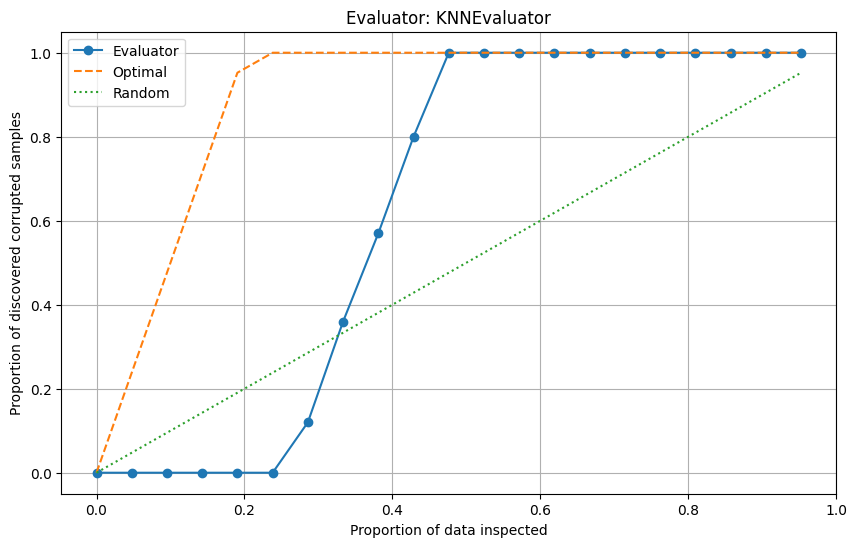

LavaEvaluator: {'found_rates': [0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


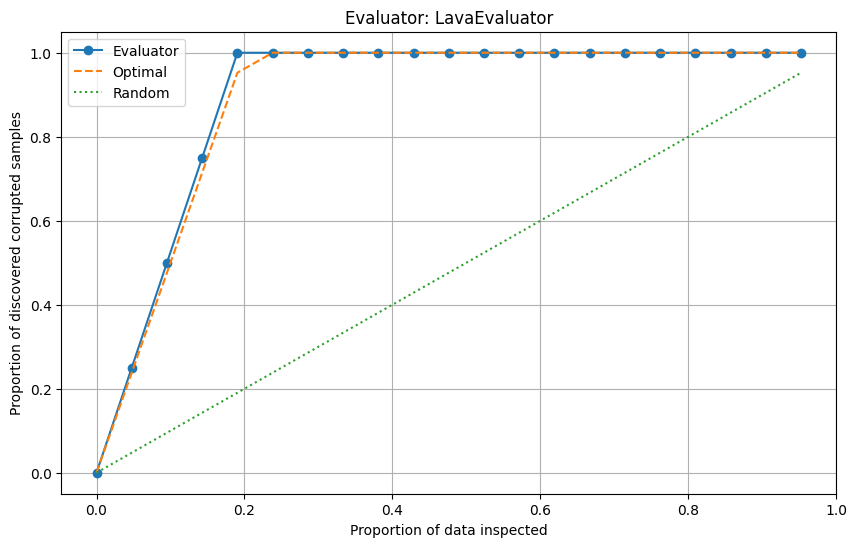

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.12,
   0.36,
   0.57,
   0.8,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.25,
   0.5,
   0.75,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.1904761904761

In [10]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_noisy, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [16]:
# Bật autoreload
%load_ext autoreload
%autoreload 2

In [17]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_imdb.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(500, 768) (300, 768) (200, 768)
(500,) (300,) (200,)


In [18]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

300
Noisy training labels shape: (500,)
Epoch [10/1000], Loss: 0.6432
Epoch [20/1000], Loss: 0.6176
Epoch [30/1000], Loss: 0.5973
Epoch [40/1000], Loss: 0.5934
Epoch [50/1000], Loss: 0.5838
Epoch [60/1000], Loss: 0.5725
Epoch [70/1000], Loss: 0.5684
Epoch [80/1000], Loss: 0.5670
Epoch [90/1000], Loss: 0.5651
Epoch [100/1000], Loss: 0.5576
Epoch [110/1000], Loss: 0.5532
Epoch [120/1000], Loss: 0.5553
Epoch [130/1000], Loss: 0.5481
Epoch [140/1000], Loss: 0.5432
Epoch [150/1000], Loss: 0.5416
Epoch [160/1000], Loss: 0.5406
Epoch [170/1000], Loss: 0.5393
Epoch [180/1000], Loss: 0.5367
Epoch [190/1000], Loss: 0.5339
Epoch [200/1000], Loss: 0.5293
Epoch [210/1000], Loss: 0.5305
Epoch [220/1000], Loss: 0.5330
Epoch [230/1000], Loss: 0.5247
Epoch [240/1000], Loss: 0.5282
Epoch [250/1000], Loss: 0.5255
Epoch [260/1000], Loss: 0.5214
Epoch [270/1000], Loss: 0.5238
Epoch [280/1000], Loss: 0.5191
Epoch [290/1000], Loss: 0.5181
Epoch [300/1000], Loss: 0.5185
Epoch [310/1000], Loss: 0.5122
Epoch [3

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 499/499 [00:00<00:00, 6358.52it/s]

KNNEvaluator completed in 0.16 seconds.
Running evaluator: LavaEvaluator


C1 shape: torch.Size([1, 500, 300])
C2 shape: torch.Size([1, 500, 300])
C1: tensor([[[4.3291, 6.6256, 8.3782,  ..., 6.2487, 7.2799, 8.6451],
         [6.3899, 6.5291, 7.6399,  ..., 5.7554, 7.5797, 7.1779],
         [4.9791, 4.8113, 6.3299,  ..., 6.3715, 8.2676, 7.8722],
         ...,
         [5.3962, 6.3970, 5.2167,  ..., 6.2271, 7.3398, 5.1944],
         [4.5979, 7.4520, 5.8570,  ..., 3.5817, 4.6774, 4.5399],
         [3.2585, 5.6113, 5.1248,  ..., 3.7839, 6.0883, 4.3908]]])
C2: tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])
C1: tensor([[[0.1262, 0.2343, 0.3169,  ..., 0.2166, 0.2651, 0.3294],
         [0.2232, 0.2298, 0.2821,  ..., 0.1933, 0.2793, 0.2603],
         [0.1568, 0.1489, 0.2204,  ..., 0.2224, 0.3117, 0.2930],
         ...,
         [0.1764, 0.2236, 0.1680,  ...,

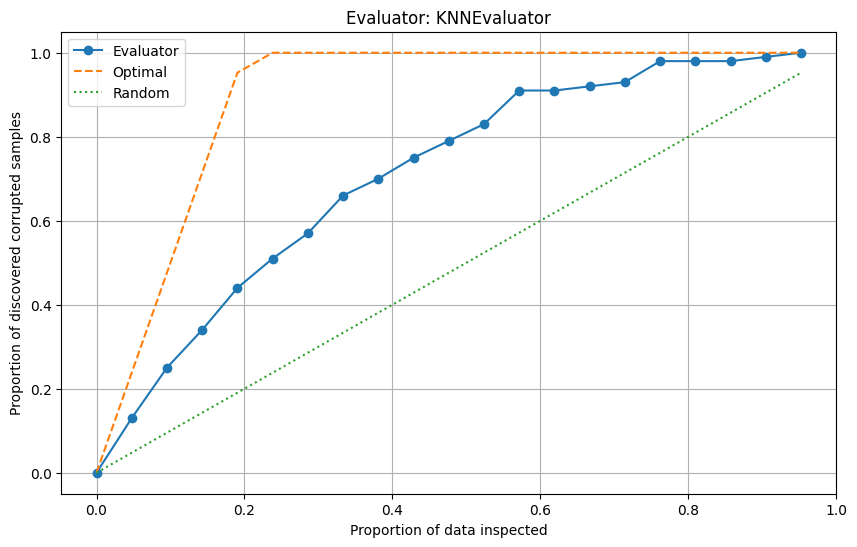

LavaEvaluator: {'found_rates': [0.0, 0.05, 0.14, 0.19, 0.24, 0.31, 0.38, 0.4, 0.45, 0.52, 0.58, 0.67, 0.72, 0.75, 0.82, 0.87, 0.9, 0.93, 0.96, 0.99, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


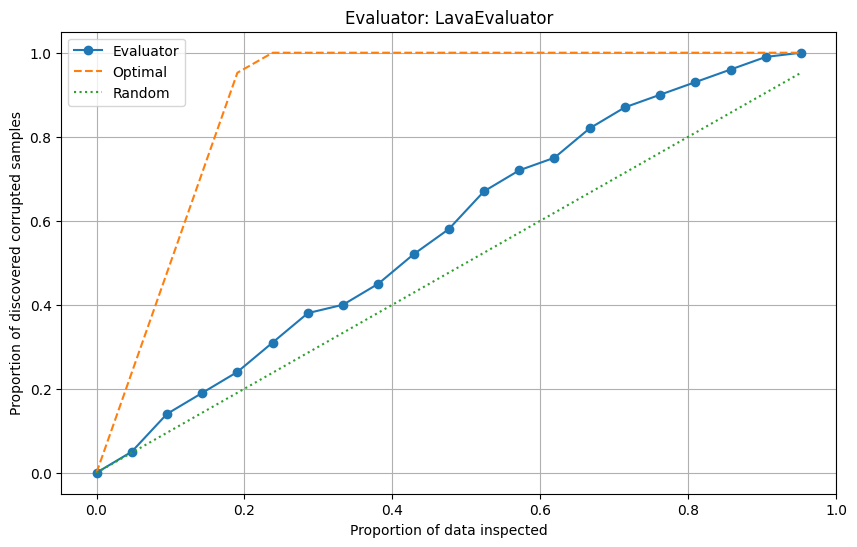

{'KNNEvaluator': {'found_rates': [0.0,
   0.13,
   0.25,
   0.34,
   0.44,
   0.51,
   0.57,
   0.66,
   0.7,
   0.75,
   0.79,
   0.83,
   0.91,
   0.91,
   0.92,
   0.93,
   0.98,
   0.98,
   0.98,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.05,
   0.14,
   0.19,
   0.24,
   0.31,
   0.38,
   0.4,
   0.45,
   0.52,
   0.58,
   0.67,
   0.72,
   0.75,
   0.82,
   0.87,
   0.9,
   0.93,
   0.96,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.1428571

In [19]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [20]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = x_embeddings.copy()
param = add_gauss_noise(X_copy, xt_embeddings, noise_rate=0.2)
X_train_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_noisy.shape)
# train model logistic regression
input_dim = X_train_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: (500, 768)
Epoch [10/1000], Loss: 0.5415
Epoch [20/1000], Loss: 0.5056
Epoch [30/1000], Loss: 0.4843
Epoch [40/1000], Loss: 0.4747
Epoch [50/1000], Loss: 0.4638
Epoch [60/1000], Loss: 0.4558
Epoch [70/1000], Loss: 0.4485
Epoch [80/1000], Loss: 0.4439
Epoch [90/1000], Loss: 0.4451
Epoch [100/1000], Loss: 0.4365
Epoch [110/1000], Loss: 0.4337
Epoch [120/1000], Loss: 0.4328
Epoch [130/1000], Loss: 0.4276
Epoch [140/1000], Loss: 0.4258
Epoch [150/1000], Loss: 0.4253
Epoch [160/1000], Loss: 0.4225
Epoch [170/1000], Loss: 0.4207
Epoch [180/1000], Loss: 0.4210
Epoch [190/1000], Loss: 0.4199
Epoch [200/1000], Loss: 0.4138
Epoch [210/1000], Loss: 0.4154
Epoch [220/1000], Loss: 0.4136
Epoch [230/1000], Loss: 0.4116
Epoch [240/1000], Loss: 0.4113
Epoch [250/1000], Loss: 0.4101
Epoch [260/1000], Loss: 0.4063
Epoch [270/1000], Loss: 0.4062
Epoch [280/1000], Loss: 0.4060
Epoch [290/1000], Loss: 0.4063
Epoch [300/1000], Loss: 0.4050
Epoch [310/1000], Loss: 0.4030
Epoch [3

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 499/499 [00:00<00:00, 8304.27it/s]

KNNEvaluator completed in 0.14 seconds.
Running evaluator: LavaEvaluator


C1 shape: torch.Size([1, 500, 300])
C2 shape: torch.Size([1, 500, 300])
C1: tensor([[[  4.3291, 382.6060,   8.3782,  ...,   6.2487, 372.1006, 379.4364],
         [415.5828, 757.9561, 419.8886,  ..., 416.2645, 811.4714, 828.6723],
         [  4.9791, 382.2868,   6.3299,  ...,   6.3715, 373.1269, 377.3043],
         ...,
         [  5.3962, 382.6605,   5.2167,  ...,   6.2271, 373.6762, 378.2625],
         [  4.5979, 384.0905,   5.8570,  ...,   3.5817, 369.7249, 379.3459],
         [  3.2585, 383.7512,   5.1248,  ...,   3.7839, 372.5269, 374.7562]]])
C2: tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])
C1: tensor([[[0.0028, 0.4182, 0.0072,  ..., 0.0049, 0.4066, 0.4147],
         [0.4544, 0.8304, 0.4591,  ..., 0.4551, 0.8891, 0.9080],
         [0.0035, 0.4178, 0.0050,  ..., 0.0050

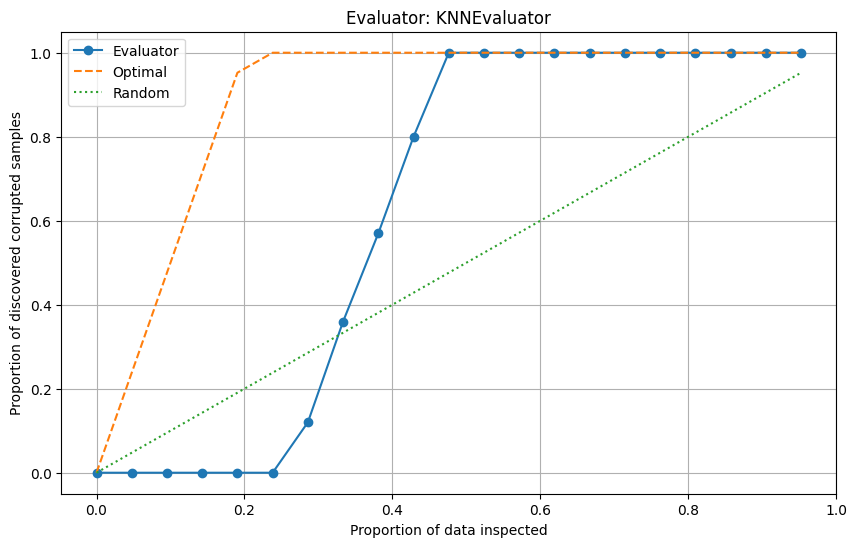

LavaEvaluator: {'found_rates': [0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


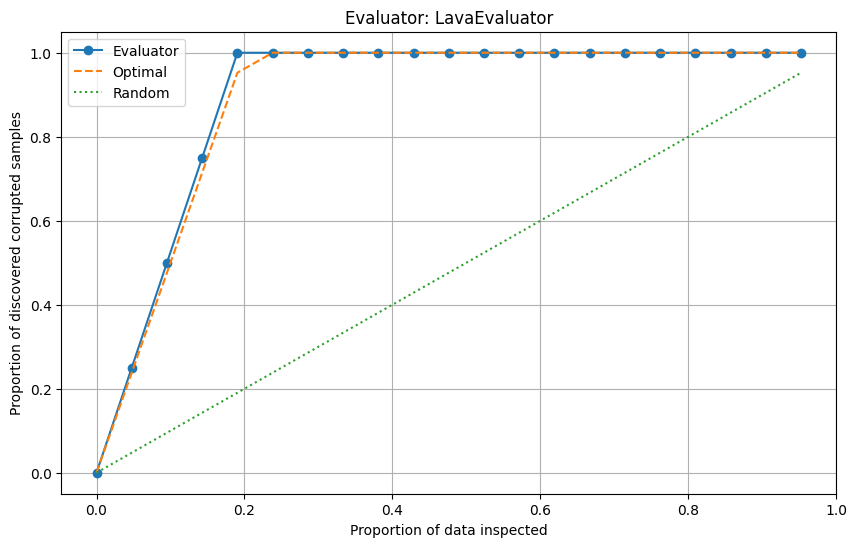

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.12,
   0.36,
   0.57,
   0.8,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.25,
   0.5,
   0.75,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.1904761904761

In [21]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_noisy, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [22]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_bbc.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(1000, 768) (600, 768) (400, 768)
(1000,) (600,) (400,)


In [24]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 1.3027
Epoch [20/1000], Loss: 1.2084
Epoch [30/1000], Loss: 1.1776
Epoch [40/1000], Loss: 1.1634
Epoch [50/1000], Loss: 1.1550
Epoch [60/1000], Loss: 1.1592
Epoch [70/1000], Loss: 1.1448
Epoch [80/1000], Loss: 1.1465
Epoch [90/1000], Loss: 1.1436
Epoch [100/1000], Loss: 1.1347
Epoch [110/1000], Loss: 1.1340
Epoch [120/1000], Loss: 1.1409
Epoch [130/1000], Loss: 1.1321
Epoch [140/1000], Loss: 1.1270
Epoch [150/1000], Loss: 1.1256
Epoch [160/1000], Loss: 1.1260
Epoch [170/1000], Loss: 1.1241
Epoch [180/1000], Loss: 1.1280
Epoch [190/1000], Loss: 1.1265
Epoch [200/1000], Loss: 1.1272
Epoch [210/1000], Loss: 1.1246
Epoch [220/1000], Loss: 1.1188
Epoch [230/1000], Loss: 1.1263
Epoch [240/1000], Loss: 1.1259
Epoch [250/1000], Loss: 1.1198
Epoch [260/1000], Loss: 1.1160
Epoch [270/1000], Loss: 1.1175
Epoch [280/1000], Loss: 1.1235
Epoch [290/1000], Loss: 1.1200
Epoch [300/1000], Loss: 1.1140
Epoch [310/1000], Loss: 1.1166
Epoch [

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 2901.99it/s]


KNNEvaluator completed in 0.60 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 9.9047,  7.9680,  7.3558,  ..., 12.4887,  4.7970,  8.4488],
        [11.3581, 10.8183,  9.7558,  ..., 14.2130,  3.8692, 10.2854],
        [ 8.9823,  6.0890,  7.3901,  ..., 12.1919, 12.1854, 11.3962],
        ...,
        [ 8.7186,  8.4631,  8.4106,  ..., 11.1005, 11.3838, 10.3768],
        [ 9.3555,  6.4731,  7.4967,  ..., 12.0395,  7.6578,  7.7956],
        [ 9.5313,  9.7148, 10.6286,  ..., 12.2989,  8.6656,  9.7812]])
C2 la: tensor([[0.3810, 0.3300, 0.3300,  ..., 0.3810, 0.0000, 0.3573],
        [0.3612, 0.4404, 0.4404,  ..., 0.3612, 0.3573, 0.0000],
        [0.3612, 0.4404, 0.4404,  ..., 0.3612, 0.3573, 0.0000],
        ...,
        [0.3612, 0.4404, 0.4404,  ..., 0.3612, 0.3573, 0.0000],
        [0.3810, 0.3300, 0.3300,  ..., 0.3810, 0.0000, 0.3573],
        [0.3944, 0.3758, 0.3758,  ..., 0.3944, 0.3209, 0.4047]])
C1 la: tensor([[0.3664, 0.2947, 0.2721,  ..., 0.4619, 0.1774, 0.3125],
        [0.4201, 0.4001, 0.3608,  ..., 0.5257, 0.1431, 0.3804],
        [0.3322, 0.

   50|3.529132e-09|
   60|3.300944e-09|
   70|3.536804e-09|
   80|3.259629e-09|
   90|3.523367e-09|
  100|3.536804e-09|
  110|3.465190e-09|
  120|3.437703e-09|
  130|3.408008e-09|
  140|3.108529e-09|
  150|3.230394e-09|
  160|3.323448e-09|
  170|3.171116e-09|
  180|2.861071e-09|
  190|2.730181e-09|
It.  |Err         
-------------------
  200|2.697722e-09|
  210|2.371561e-09|
  220|2.114789e-09|
  230|2.133928e-09|
  240|2.307844e-09|
  250|2.408419e-09|
  260|2.507663e-09|
  270|2.584840e-09|
  280|2.710253e-09|
  290|2.515756e-09|
  300|2.988497e-09|
  310|2.891697e-09|
  320|2.707751e-09|
  330|2.385804e-09|
  340|2.539883e-09|
  350|2.290159e-09|
  360|2.162319e-09|
  370|2.156042e-09|
  380|1.948001e-09|
  390|2.187245e-09|
It.  |Err         
-------------------
  400|2.523824e-09|
  410|2.740091e-09|
  420|2.458542e-09|
  430|2.095476e-09|
  440|1.992709e-09|
  450|2.397138e-09|
  460|2.405604e-09|
  470|2.348591e-09|
  480|2.507663e-09|
  490|2.199603e-09|
  500|2.184145e-09|
  

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


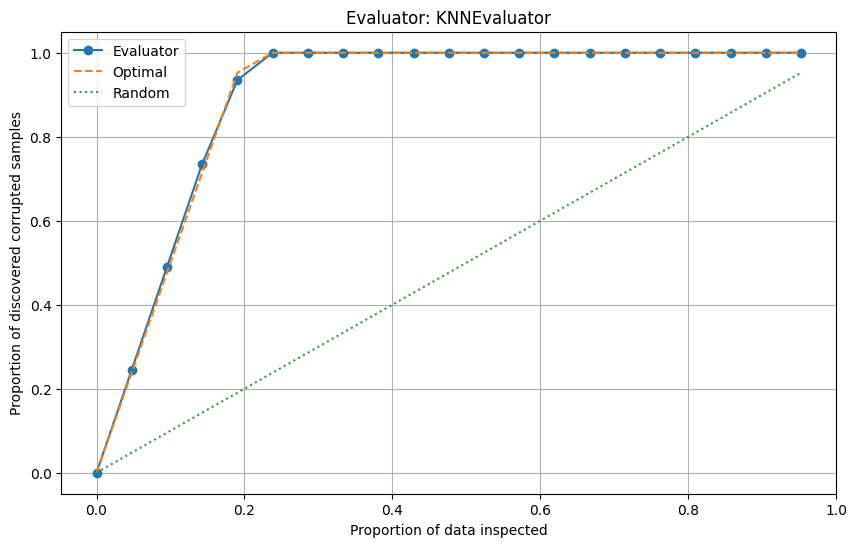

LavaEvaluator: {'found_rates': [0.0, 0.16, 0.3, 0.375, 0.46, 0.52, 0.58, 0.615, 0.655, 0.69, 0.72, 0.74, 0.755, 0.82, 0.88, 0.925, 0.96, 0.99, 0.995, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


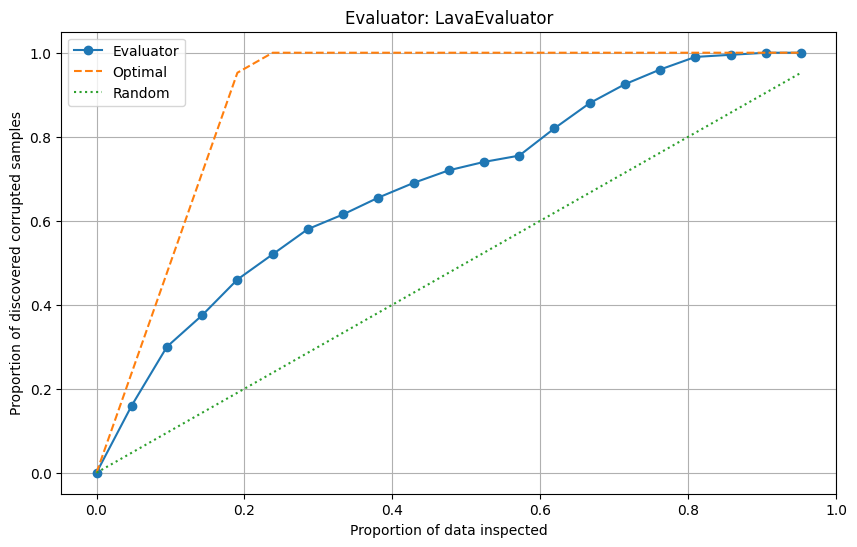

{'KNNEvaluator': {'found_rates': [0.0,
   0.245,
   0.49,
   0.735,
   0.935,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.16,
   0.3,
   0.375,
   0.46,
   0.52,
   0.58,
   0.615,
   0.655,
   0.69,
   0.72,
   0.74,
   0.755,
   0.82,
   0.88,
   0.925,
   0.96,
   0.99,
   0.995,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.142857142857

In [25]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [23]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = x_embeddings.copy()
param = add_gauss_noise(X_copy, xt_embeddings, noise_rate=0.2)
X_train_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_noisy.shape)
# train model logistic regression
input_dim = X_train_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: (1000, 768)
Epoch [10/1000], Loss: 1.1007
Epoch [20/1000], Loss: 1.0165
Epoch [30/1000], Loss: 0.9888
Epoch [40/1000], Loss: 0.9739
Epoch [50/1000], Loss: 0.9664
Epoch [60/1000], Loss: 0.9590
Epoch [70/1000], Loss: 0.9580
Epoch [80/1000], Loss: 0.9539
Epoch [90/1000], Loss: 0.9480
Epoch [100/1000], Loss: 0.9472
Epoch [110/1000], Loss: 0.9443
Epoch [120/1000], Loss: 0.9423
Epoch [130/1000], Loss: 0.9405
Epoch [140/1000], Loss: 0.9419
Epoch [150/1000], Loss: 0.9392
Epoch [160/1000], Loss: 0.9369
Epoch [170/1000], Loss: 0.9360
Epoch [180/1000], Loss: 0.9348
Epoch [190/1000], Loss: 0.9345
Epoch [200/1000], Loss: 0.9329
Epoch [210/1000], Loss: 0.9325
Epoch [220/1000], Loss: 0.9342
Epoch [230/1000], Loss: 0.9318
Epoch [240/1000], Loss: 0.9304
Epoch [250/1000], Loss: 0.9315
Epoch [260/1000], Loss: 0.9317
Epoch [270/1000], Loss: 0.9286
Epoch [280/1000], Loss: 0.9304
Epoch [290/1000], Loss: 0.9279
Epoch [300/1000], Loss: 0.9282
Epoch [310/1000], Loss: 0.9268
Epoch [

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 999/999 [00:00<00:00, 4921.09it/s]


KNNEvaluator completed in 0.44 seconds.
Running evaluator: LavaEvaluator
C1 shape: torch.Size([1, 1000, 600])
C2 shape: torch.Size([1, 1000, 600])
C1: tensor([[[  9.9047,   7.9679,   7.3558,  ...,  12.4887,   4.7970, 363.7947],
         [405.7866, 407.6549, 403.5032,  ..., 410.8563, 393.6965, 724.8872],
         [  8.9823,   6.0890,   7.3901,  ...,  12.1918,  12.1854, 366.8277],
         ...,
         [  8.7186,   8.4631,   8.4106,  ...,  11.1005,  11.3838, 363.2072],
         [  9.3555,   6.4730,   7.4967,  ...,  12.0395,   7.6578, 366.5738],
         [397.0560, 390.4076, 391.6656,  ..., 397.8917, 393.6507, 731.6136]]])
C2: tensor([[[1., 2., 2.,  ..., 1., 0., 1.],
         [1., 2., 2.,  ..., 1., 0., 1.],
         [3., 4., 4.,  ..., 3., 2., 1.],
         ...,
         [3., 4., 4.,  ..., 3., 2., 1.],
         [1., 2., 2.,  ..., 1., 0., 1.],
         [1., 2., 2.,  ..., 1., 0., 1.]]])
C1: tensor([[[0.0103, 0.0083, 0.0077,  ..., 0.0130, 0.0050, 0.3798],
         [0.4236, 0.4256, 0.4212,  .

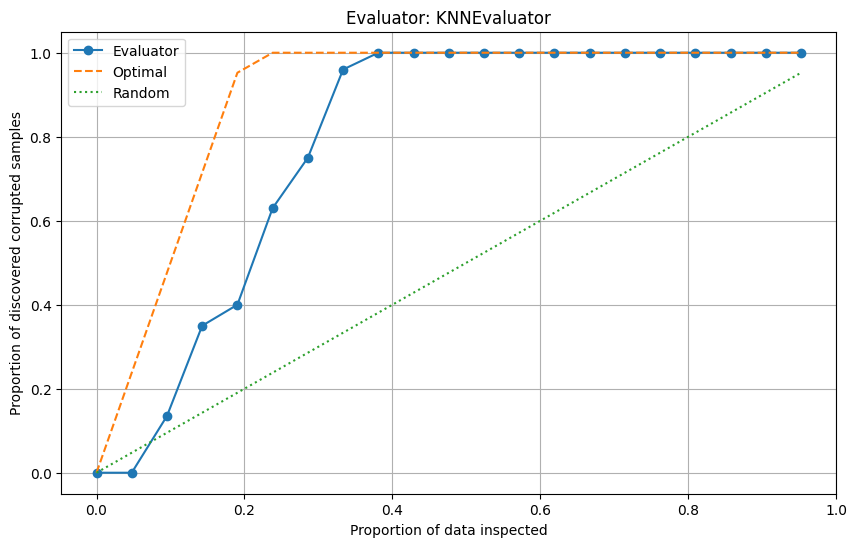

LavaEvaluator: {'found_rates': [0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


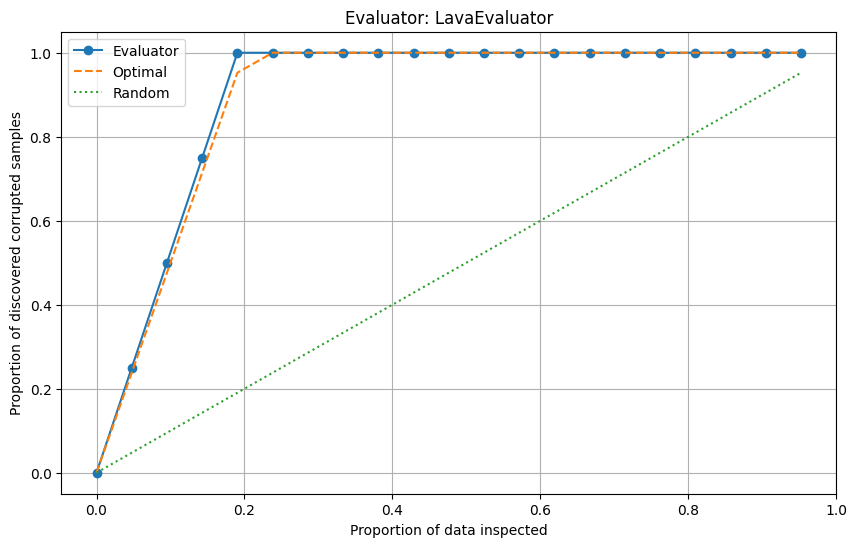

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.135,
   0.35,
   0.4,
   0.63,
   0.75,
   0.96,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.25,
   0.5,
   0.75,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.1904761904

In [24]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_noisy, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [36]:
import requests
from pathlib import Path
from tqdm import tqdm
def download_sst2(cache_dir, force_download=False):
    """Download and prepare the SST-2 sentiment analysis dataset (binary)."""
    ensure_directory_exists(cache_dir)
    github_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
    file_path = Path(cache_dir) / "sst2.csv"

    # Check cache first
    if "sst2" in data_cache and not force_download:
        return data_cache["sst2"]

    # Download if not exists or force download
    if not file_path.exists() or force_download:
        df = pd.read_csv(github_url, delimiter='\t', header=None, names=["text", "label"])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)

    # Lấy 2000 mẫu
    df = df.sample(n=2000, random_state=42) if len(df) > 2000 else df
    labels = df["label"].values

    # Cache
    data_cache["sst2"] = (df["text"].values, labels)
    return data_cache["sst2"]


def download_trec6(cache_dir, force_download=False):
    """Download and prepare the TREC-6 question classification dataset."""
    ensure_directory_exists(cache_dir)
    github_url = "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label"
    file_path = Path(cache_dir) / "trec6.csv"

    # Check cache first
    if "trec6" in data_cache and not force_download:
        return data_cache["trec6"]

    # Download if not exists or force download
    if not file_path.exists() or force_download:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(requests.get(github_url).text)
        df = pd.read_csv(file_path, sep=":", header=None, names=["label_text", "text"])
    else:
        df = pd.read_csv(file_path, sep=":", header=None, names=["label_text", "text"])

    # Chuyển label thành dạng số
    label_dict = {
        "DESC": 0,
        "ENTY": 1,
        "ABBR": 2,
        "HUM": 3,
        "LOC": 4,
        "NUM": 5,
    }
    labels = np.array([label_dict[label.split()[0]] for label in df["label_text"]])

    # Lấy 2000 mẫu
    df = df.sample(n=2000, random_state=42) if len(df) > 2000 else df

    # Cache
    data_cache["trec6"] = (df["text"].values, labels)
    return data_cache["trec6"]



# Load and prepare SST-2 embeddings
# cache_dir = "./cache"
# sst2_data, sst2_labels = download_sst2(cache_dir)
# sst2_data, sst2_labels = subsample_data(sst2_data, sst2_labels, num_samples=2000, random_state=42)
# sst2_embeddings = prepare_embeddings(sst2_data, cache_dir=cache_dir)

# Load and prepare TREC-6 embeddings
# trec6_data, trec6_labels = download_trec6(cache_dir)
# trec6_embeddings = prepare_embeddings(trec6_data, cache_dir=cache_dir)


In [29]:
# save
import pickle

with open('x_y_embedding_sst2.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [30]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_sst2.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(1000, 768) (600, 768) (400, 768)
(1000,) (600,) (400,)


In [31]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 1.2934
Epoch [20/1000], Loss: 1.2071
Epoch [30/1000], Loss: 1.1780
Epoch [40/1000], Loss: 1.1629
Epoch [50/1000], Loss: 1.1527
Epoch [60/1000], Loss: 1.1503
Epoch [70/1000], Loss: 1.1458
Epoch [80/1000], Loss: 1.1477
Epoch [90/1000], Loss: 1.1387
Epoch [100/1000], Loss: 1.1365
Epoch [110/1000], Loss: 1.1356
Epoch [120/1000], Loss: 1.1323
Epoch [130/1000], Loss: 1.1336
Epoch [140/1000], Loss: 1.1321
Epoch [150/1000], Loss: 1.1345
Epoch [160/1000], Loss: 1.1291
Epoch [170/1000], Loss: 1.1292
Epoch [180/1000], Loss: 1.1223
Epoch [190/1000], Loss: 1.1316
Epoch [200/1000], Loss: 1.1258
Epoch [210/1000], Loss: 1.1252
Epoch [220/1000], Loss: 1.1244
Epoch [230/1000], Loss: 1.1225
Epoch [240/1000], Loss: 1.1202
Epoch [250/1000], Loss: 1.1200
Epoch [260/1000], Loss: 1.1198
Epoch [270/1000], Loss: 1.1297
Epoch [280/1000], Loss: 1.1148
Epoch [290/1000], Loss: 1.1173
Epoch [300/1000], Loss: 1.1195
Epoch [310/1000], Loss: 1.1189
Epoch [

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 999/999 [00:00<00:00, 4855.06it/s]


KNNEvaluator completed in 0.59 seconds.
Running evaluator: LavaEvaluator
C1 shape: torch.Size([1, 1000, 600])
C2 shape: torch.Size([1, 1000, 600])
C1: tensor([[[  9.9047,   7.9679,   7.3558,  ...,  12.4887,   4.7970, 363.7947],
         [ 11.3581,  10.8183,   9.7558,  ...,  14.2130,   3.8692, 368.2547],
         [  8.9823,   6.0890,   7.3901,  ...,  12.1918,  12.1854, 366.8277],
         ...,
         [  8.7186,   8.4631,   8.4106,  ...,  11.1005,  11.3838, 363.2072],
         [  9.3555,   6.4730,   7.4967,  ...,  12.0395,   7.6578, 366.5738],
         [  9.5313,   9.7148,  10.6286,  ...,  12.2989,   8.6656, 368.4171]]])
C2: tensor([[[1., 2., 2.,  ..., 1., 0., 2.],
         [3., 4., 4.,  ..., 3., 2., 0.],
         [3., 4., 4.,  ..., 3., 2., 0.],
         ...,
         [3., 4., 4.,  ..., 3., 2., 0.],
         [1., 2., 2.,  ..., 1., 0., 2.],
         [2., 3., 3.,  ..., 2., 1., 1.]]])
C1: tensor([[[0.0216, 0.0174, 0.0160,  ..., 0.0272, 0.0105, 0.7925],
         [0.0247, 0.0236, 0.0213,  .

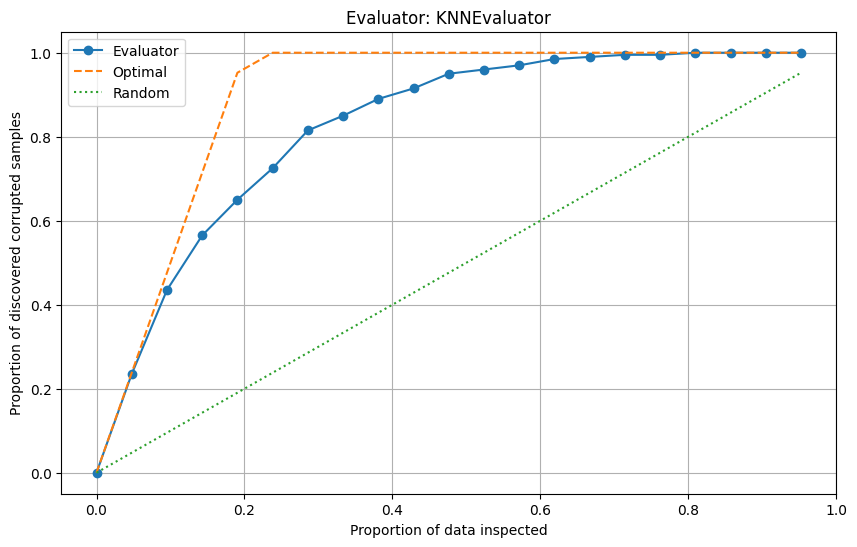

LavaEvaluator: {'found_rates': [0.0, 0.14, 0.18, 0.205, 0.225, 0.28, 0.38, 0.44, 0.47, 0.505, 0.56, 0.62, 0.65, 0.695, 0.775, 0.825, 0.88, 0.925, 0.96, 0.985, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


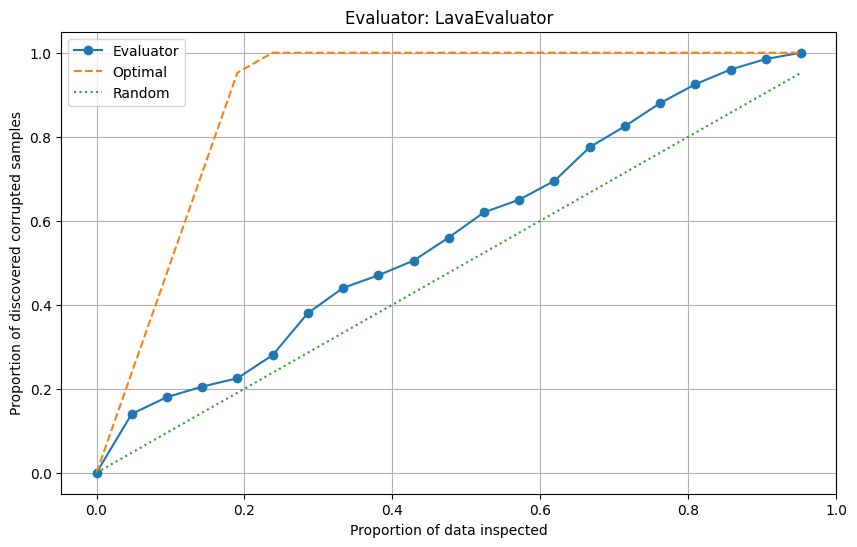

{'KNNEvaluator': {'found_rates': [0.0,
   0.235,
   0.435,
   0.565,
   0.65,
   0.725,
   0.815,
   0.85,
   0.89,
   0.915,
   0.95,
   0.96,
   0.97,
   0.985,
   0.99,
   0.995,
   0.995,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.14,
   0.18,
   0.205,
   0.225,
   0.28,
   0.38,
   0.44,
   0.47,
   0.505,
   0.56,
   0.62,
   0.65,
   0.695,
   0.775,
   0.825,
   0.88,
   0.925,
   0.96,
   0.985,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809

In [32]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [33]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = x_embeddings.copy()
param = add_gauss_noise(X_copy, xt_embeddings, noise_rate=0.2)
X_train_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_noisy.shape)
# train model logistic regression
input_dim = X_train_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: (1000, 768)
Epoch [10/1000], Loss: 1.1077
Epoch [20/1000], Loss: 1.0189
Epoch [30/1000], Loss: 0.9907
Epoch [40/1000], Loss: 0.9750
Epoch [50/1000], Loss: 0.9682
Epoch [60/1000], Loss: 0.9601
Epoch [70/1000], Loss: 0.9557
Epoch [80/1000], Loss: 0.9518
Epoch [90/1000], Loss: 0.9492
Epoch [100/1000], Loss: 0.9453
Epoch [110/1000], Loss: 0.9438
Epoch [120/1000], Loss: 0.9414
Epoch [130/1000], Loss: 0.9415
Epoch [140/1000], Loss: 0.9412
Epoch [150/1000], Loss: 0.9372
Epoch [160/1000], Loss: 0.9366
Epoch [170/1000], Loss: 0.9360
Epoch [180/1000], Loss: 0.9340
Epoch [190/1000], Loss: 0.9335
Epoch [200/1000], Loss: 0.9332
Epoch [210/1000], Loss: 0.9315
Epoch [220/1000], Loss: 0.9309
Epoch [230/1000], Loss: 0.9302
Epoch [240/1000], Loss: 0.9304
Epoch [250/1000], Loss: 0.9312
Epoch [260/1000], Loss: 0.9286
Epoch [270/1000], Loss: 0.9279
Epoch [280/1000], Loss: 0.9273
Epoch [290/1000], Loss: 0.9291
Epoch [300/1000], Loss: 0.9264
Epoch [310/1000], Loss: 0.9264
Epoch [

Running evaluator: KNNEvaluator


Computing Shapley Values: 100%|██████████| 999/999 [00:00<00:00, 5126.18it/s]


KNNEvaluator completed in 0.50 seconds.
Running evaluator: LavaEvaluator
C1 shape: torch.Size([1, 1000, 600])
C2 shape: torch.Size([1, 1000, 600])
C1: tensor([[[   9.9047,    7.9679,    7.3558,  ...,   12.4887,    4.7970,
          1434.4548],
         [ 405.7866,  407.6549,  403.5032,  ...,  410.8563,  393.6965,
          1766.0651],
         [   8.9823,    6.0890,    7.3901,  ...,   12.1918,   12.1854,
          1437.5734],
         ...,
         [   8.7186,    8.4631,    8.4106,  ...,   11.1005,   11.3838,
          1431.3517],
         [   9.3555,    6.4730,    7.4967,  ...,   12.0395,    7.6578,
          1440.6661],
         [ 397.0560,  390.4076,  391.6656,  ...,  397.8917,  393.6507,
          1778.4240]]])
C2: tensor([[[1., 2., 2.,  ..., 1., 0., 2.],
         [1., 2., 2.,  ..., 1., 0., 2.],
         [3., 4., 4.,  ..., 3., 2., 0.],
         ...,
         [3., 4., 4.,  ..., 3., 2., 0.],
         [1., 2., 2.,  ..., 1., 0., 2.],
         [1., 2., 2.,  ..., 1., 0., 2.]]])
C1: tenso

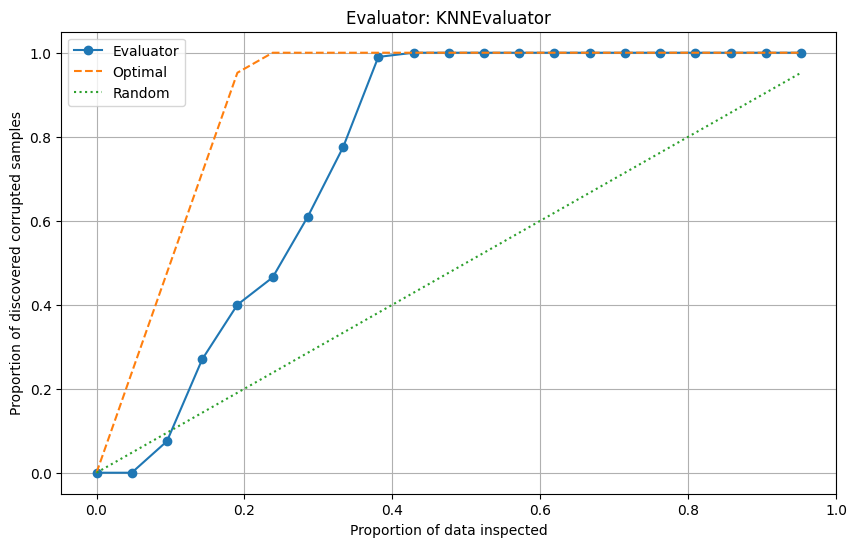

LavaEvaluator: {'found_rates': [0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


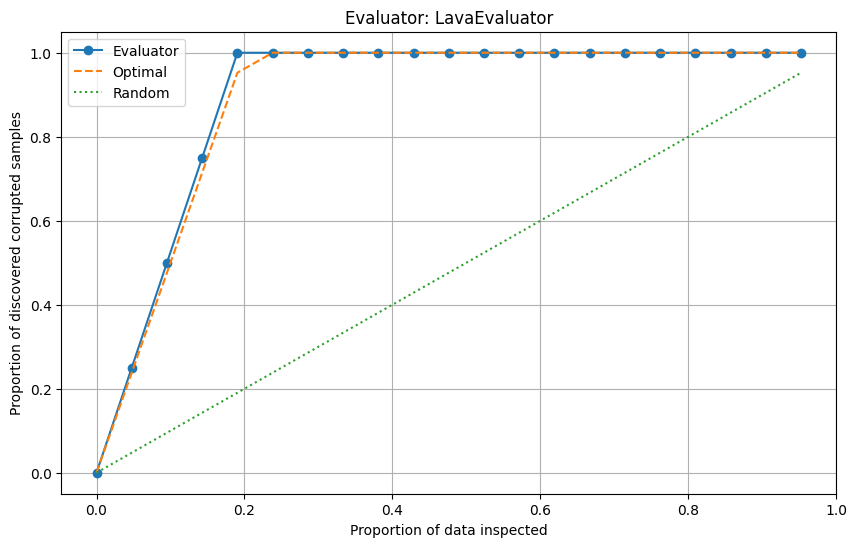

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.075,
   0.27,
   0.4,
   0.465,
   0.61,
   0.775,
   0.99,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.25,
   0.5,
   0.75,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.1904761

In [34]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_noisy, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)